## Import packages

In [104]:
import numpy as np
from skimage.io import imread, imshow

## Import image

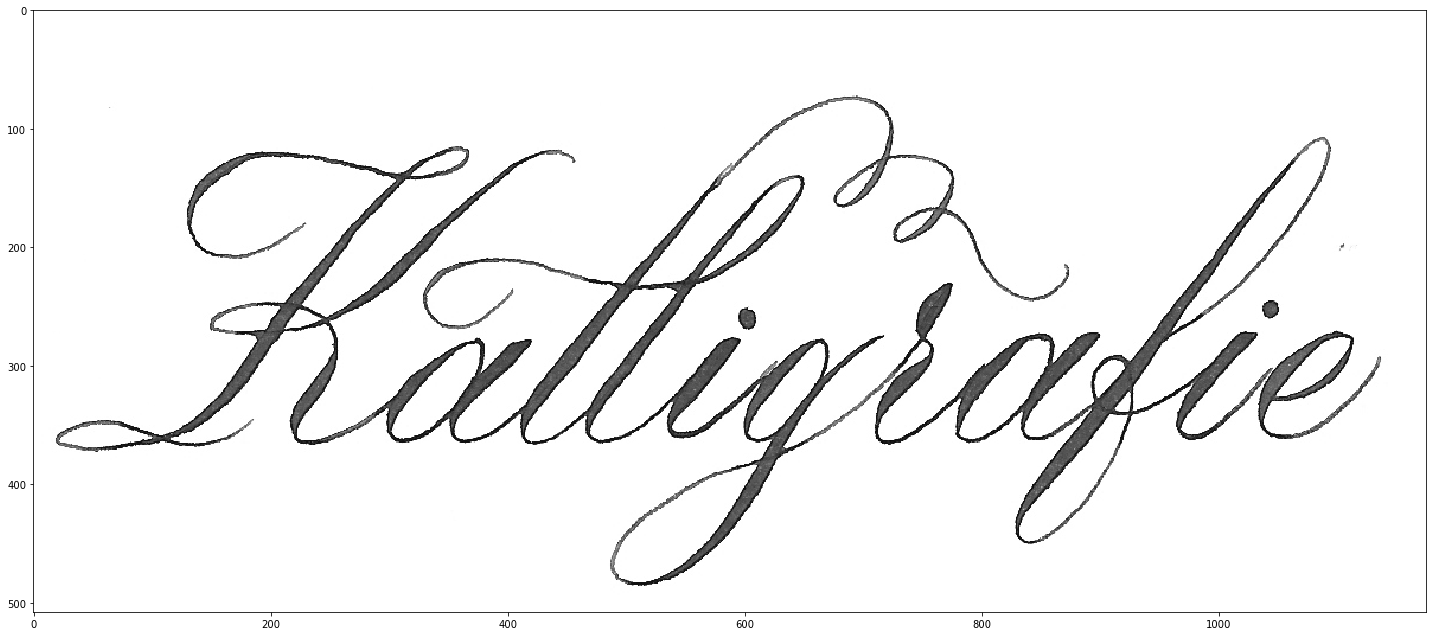

In [105]:
scan = imread('test-files/kalligrafie.png', as_gray=True)
imshow(scan)

## Convert image to binary

In [106]:
import matplotlib.pyplot as plt
import numpy as np
#plt.hist(scan)
#plt.show()

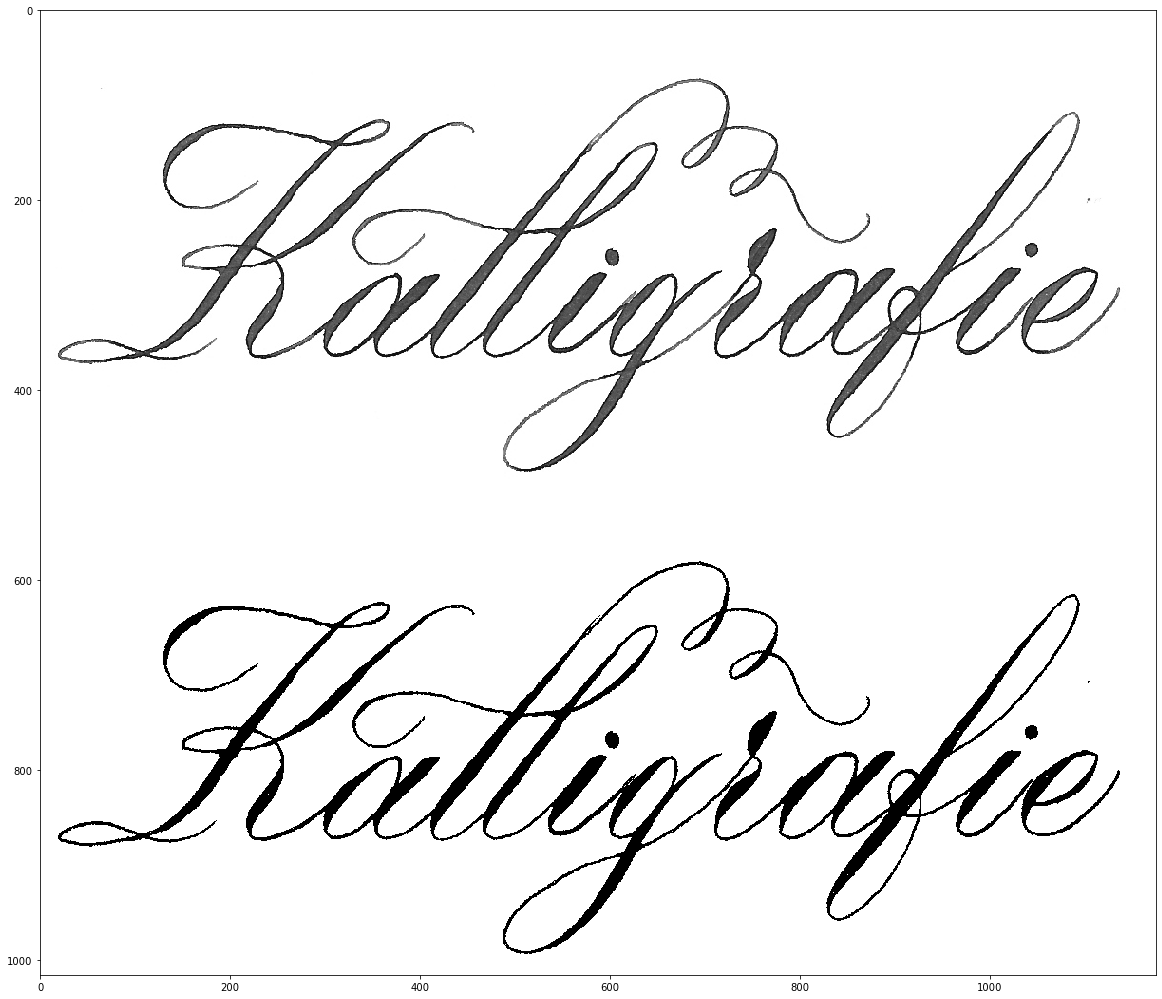

In [107]:
from skimage.filters import threshold_otsu

#threshold = 0.7
threshold = threshold_otsu(scan)

binary = scan > threshold
both = np.vstack((scan, binary))
plt.figure(figsize=(20, 20))
plt.imshow(both, cmap='gray', interpolation='nearest')

## Remove islands

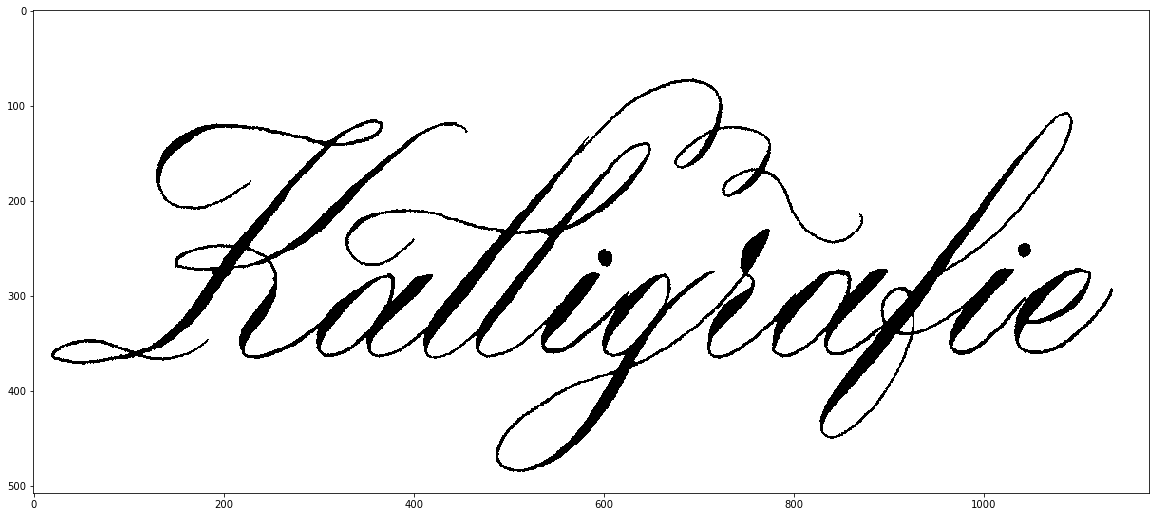

In [108]:
import skimage.morphology as mrp

footprint = np.array([
    [1, 1, 0],
    [1, 1, 1],
    [0, 1, 1]
])
footprint = np.array([
    [1, 1],
    [1, 1]
])

cleaned_image = mrp.remove_small_holes(binary)
cleaned_image = mrp.remove_small_objects(cleaned_image)

plt.imshow(cleaned_image, cmap='gray', interpolation='nearest')

## Contour tracing

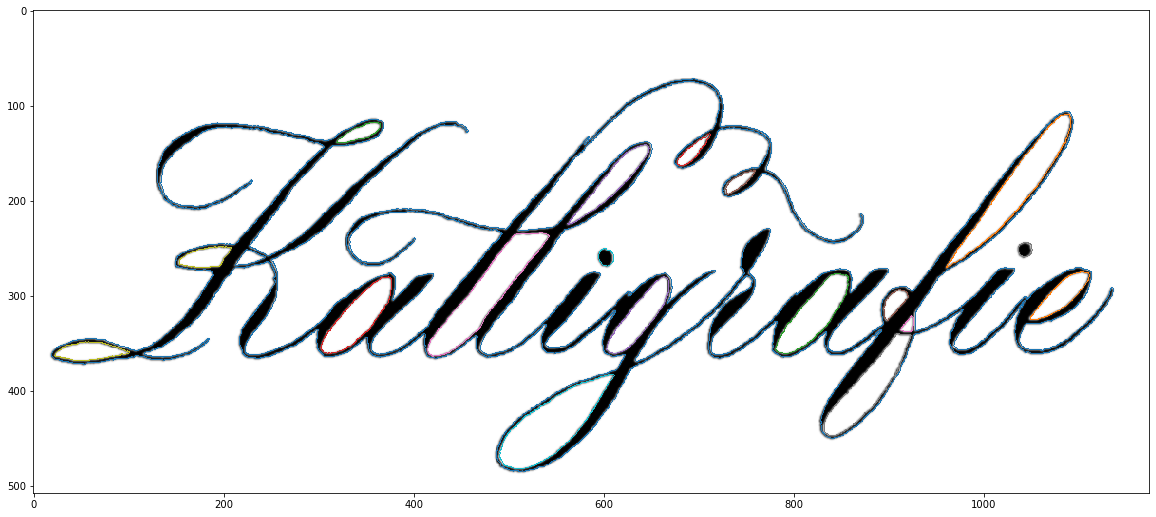

In [174]:
from skimage import measure
from skimage import filters

contours = measure.find_contours(filters.gaussian(cleaned_image, 0.5))

# Display the image and plot all contours found
plt.rcParams['figure.figsize'] = (20, 20)

fig, ax = plt.subplots()
ax.imshow(filters.gaussian(cleaned_image, 0.5), cmap='gray', interpolation='nearest')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], antialiased=False, marker=',', linestyle='none')

plt.show()

In [175]:
contours[7]

array([[ 260.        , 1042.42132283],
       [ 259.56655463, 1043.        ],
       [ 259.5       , 1044.        ],
       [ 259.43326363, 1045.        ],
       [ 259.        , 1045.4999773 ],
       [ 258.56658809, 1046.        ],
       [ 258.43338957, 1047.        ],
       [ 258.        , 1047.49098495],
       [ 257.49997799, 1048.        ],
       [ 257.        , 1048.49997799],
       [ 256.49098495, 1049.        ],
       [ 256.        , 1049.43338957],
       [ 255.        , 1049.56658809],
       [ 254.4999773 , 1050.        ],
       [ 254.        , 1050.43326363],
       [ 253.        , 1050.49985018],
       [ 252.        , 1050.49985018],
       [ 251.        , 1050.43326363],
       [ 250.5       , 1050.        ],
       [ 250.        , 1049.56673637],
       [ 249.        , 1049.50014982],
       [ 248.        , 1049.49985018],
       [ 247.        , 1049.43324124],
       [ 246.50905969, 1049.        ],
       [ 246.        , 1048.49096301],
       [ 245.56661049, 10

In [176]:
for contour in contours:
    print(len(contour))

14117
587
139
137
341
117
521
61
165
69
99
225
331
315
293
117
61
403
215
443


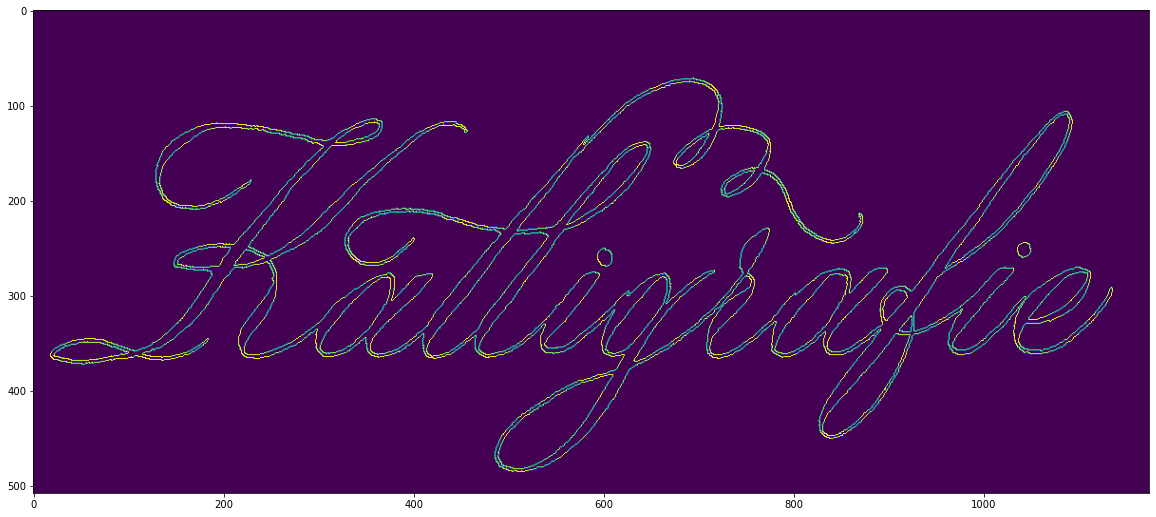

In [177]:
# Convert coordinates to image
contour_img = np.ma.array(np.zeros(np.shape(cleaned_image)))
for contour in contours:
    for pixel in np.int32(contour):
        contour_img[pixel[0], pixel[1]] = 1

plt.imshow(contour_img)

## Corner detection

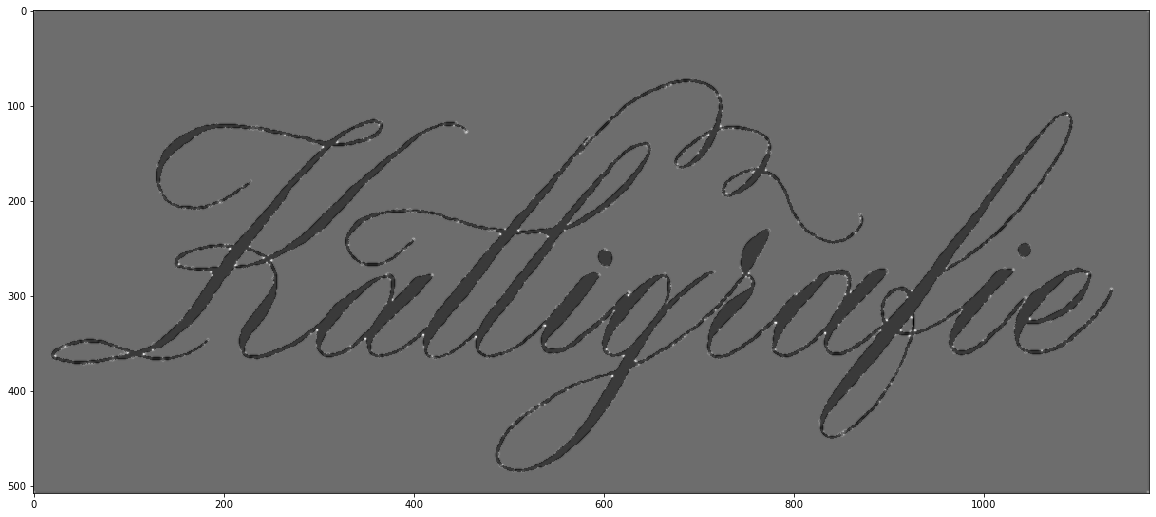

In [178]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks

corners = corner_harris(cleaned_image)

fig, ax = plt.subplots()
ax.imshow(cleaned_image, cmap=plt.cm.gray, interpolation='nearest')
ax.imshow(corners, interpolation='nearest', cmap='gray', alpha=0.8)
plt.show()

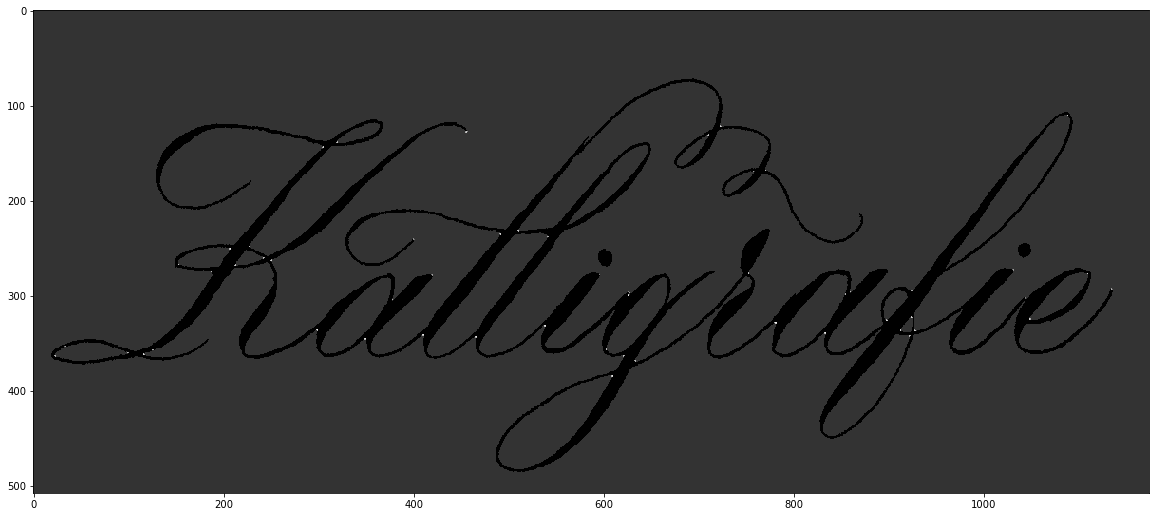

In [179]:
corners[corners < 15] = 0

fig, ax = plt.subplots()
ax.imshow(cleaned_image, cmap=plt.cm.gray, interpolation='nearest')
ax.imshow(corners, interpolation='nearest', cmap='gray', alpha=0.8)
plt.show()

[[ 127  456]
 [ 328  781]
 [ 300  626]
 [ 343  466]
 [ 336  299]
 [ 339  834]
 [ 331  539]
 [ 296  627]
 [ 341  411]
 [ 250  207]
 [ 384  610]
 [ 345  350]
 [ 293 1135]
 [ 362  116]
 [ 323  924]
 [ 122  723]
 [ 337  928]
 [ 326  898]
 [ 144  305]
 [ 263  251]
 [ 277 1110]
 [ 325 1049]
 [ 235  492]
 [ 272 1032]
 [ 278  420]
 [ 110 1089]
 [ 268  213]
 [ 267  153]
 [ 337  913]
 [ 357  603]
 [ 277  753]
 [ 248  228]
 [ 231  511]
 [ 363  621]
 [ 342  922]
 [ 131  711]
 [ 139  320]
 [ 260  242]
 [ 241  400]
 [ 168  771]
 [ 193  730]
 [ 275  187]
 [ 368  634]
 [ 360   99]
 [ 363   23]
 [ 296  860]
 [ 302 1044]
 [ 278  596]
 [ 304  378]
 [ 353   34]
 [ 357  125]
 [ 299  855]
 [ 238  541]
 [ 295  925]
 [ 169  758]]
[[485.         517.5       ]
 [484.56673633 518.        ]
 [484.50014982 519.        ]
 ...
 [481.56673637 517.        ]
 [482.         516.5       ]
 [482.43326371 516.        ]]
fallback 0 0
fallback 0 0
fallback 0 0
fallback 0 0
fallback 0 0
fallback 0 0
fallback 0 0
fallback 0 0


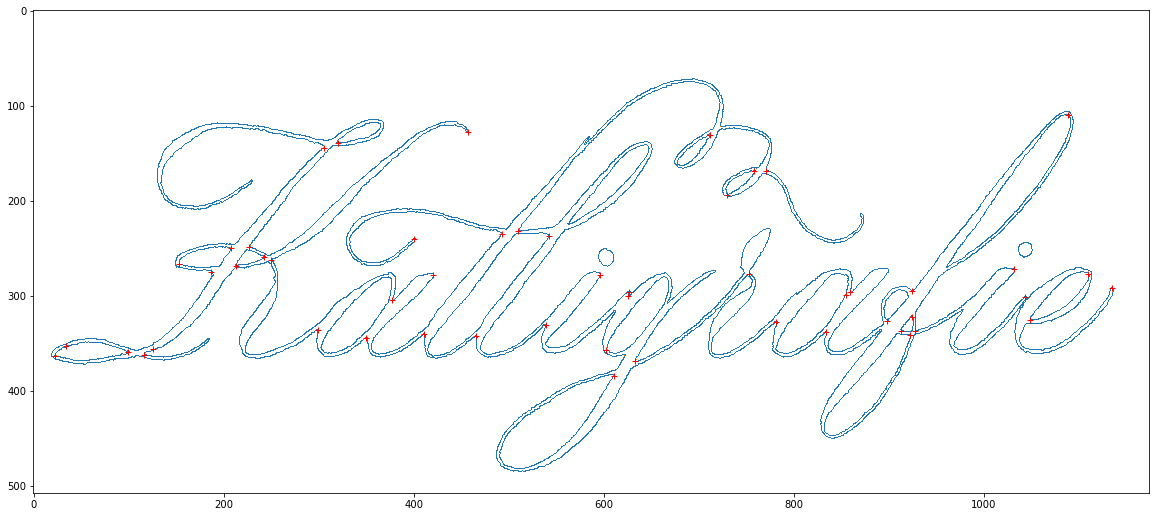

In [180]:
from skimage.feature import peak_local_max

corner_coords = peak_local_max(corners)
print(corner_coords)

x_vals = []
y_vals = []
for c in contours:
    for x in c[:, 1]:
        x_vals.append(x)
    for y in c[:, 0]:
        y_vals.append(y)

all_contours = np.array([y_vals, x_vals]).transpose()
#print(np.shape(all_contours))
print(all_contours)


##############################################################
# Move coordinates onto contour
##############################################################
corrected_corners = []
# From a corner peak local max go in x, y until you reach contour
# (max. 5 px, otherwise outside corner -> fallback to the closest contour point)
for coord in corner_coords:
    # Skip if already on contour
    if any(np.equal(all_contours, coord).all(1)):
        print('skipped')
        continue

    x = coord[1]
    y = coord[0]
    x_direction = 0
    y_direction = 0
    x_corr = 0
    y_corr = 0
    for i in range(1, 11):
        # Search x
        if x_direction == 0:
            if y == 237.5 and x == 542:
                print(x, y)

            if any(np.equal(all_contours, [y, x + i/2]).all(1)):
                x_direction = 1
                x_corr = i/2
            elif any(np.equal(all_contours, [y, x - i/2]).all(1)):
                x_direction = -1
                x_corr = -i/2

        # Search y
        if y_direction == 0:
            if any(np.equal(all_contours, [y + i/2, x]).all(1)):
                y_direction = 1
                y_corr = i/2
            elif any(np.equal(all_contours, [y - i/2, x]).all(1)):
                y_direction = -1
                y_corr = -i/2

    # Move corner
    if x_direction != 0 and y_direction != 0:
        for i in range(1, 21):
            # Move diagonal
            if any(np.equal(all_contours, [y + (i/2 * y_direction), x + (i/2 * x_direction)]).all(1)):
                corrected_corners.append(np.array([y + (i/2 * y_direction), x + (i/2 * x_direction)]))
                print('diag')
                break
            # Check adjacent pixel to not jump over a thin contour
            elif abs(x_corr) >= abs(y_corr):
                if any(np.equal(all_contours, [y + (i/2 * y_direction), x + ((i/2 - 0.5) * x_direction)]).all(1)):
                    corrected_corners.append(np.array([y + (i/2 * y_direction), x + ((i/2 - 0.5) * x_direction)]))
                    print('x+')
                    break
            else:
                if any(np.equal(all_contours, [y + ((i/2 - 0.5) * y_direction), x + (i/2 * x_direction)]).all(1)):
                    corrected_corners.append(np.array([y + ((i/2 - 0.5) * y_direction), x + (i/2 * x_direction)]))
                    print('y+')
                    break
        else:
            print(f'{coord} could not be moved to contour.')

    # Fallback to initial solution for outside corners
    else:
        print('fallback', x_direction, y_direction)
        distances = np.sqrt((all_contours[:, 0] - y) ** 2 + (all_contours[:, 1] - x) ** 2)
        corrected_corners.append(all_contours[np.argmin(distances)])

corrected_corners = np.asarray(corrected_corners)
##############################################################

fig, ax = plt.subplots()
ax.imshow(contour_img, alpha=0)  # for shape of plot
ax.plot(all_contours[:, 1], all_contours[:, 0], linestyle='none', marker=',')
ax.plot(corner_coords[:, 1], corner_coords[:, 0], antialiased=False, marker=',', linestyle='none')
ax.plot(corrected_corners[:, 1], corrected_corners[:, 0], 'r+')
plt.show()

In [181]:
corrected_corners

array([[ 127.41251013,  457.        ],
       [ 327.50035347,  781.        ],
       [ 300.4237034 ,  626.        ],
       [ 342.5762966 ,  466.        ],
       [ 335.5762966 ,  299.        ],
       [ 338.57612632,  834.        ],
       [ 331.        ,  539.42387368],
       [ 295.57629654,  627.        ],
       [ 340.57612632,  411.        ],
       [ 250.        ,  207.42387368],
       [ 384.        ,  610.42387368],
       [ 344.57612632,  350.        ],
       [ 292.        , 1135.41251006],
       [ 362.        ,  115.5761494 ],
       [ 322.        ,  924.41251013],
       [ 337.4240608 ,  928.        ],
       [ 326.43303704,  898.        ],
       [ 144.        ,  305.43303704],
       [ 262.58748987,  250.        ],
       [ 277.        , 1110.42406085],
       [ 325.4240608 , 1049.        ],
       [ 235.        ,  492.43303704],
       [ 271.5759392 , 1032.        ],
       [ 278.        ,  420.4240608 ],
       [ 109.57590519, 1089.        ],
       [ 268.49251474,  2

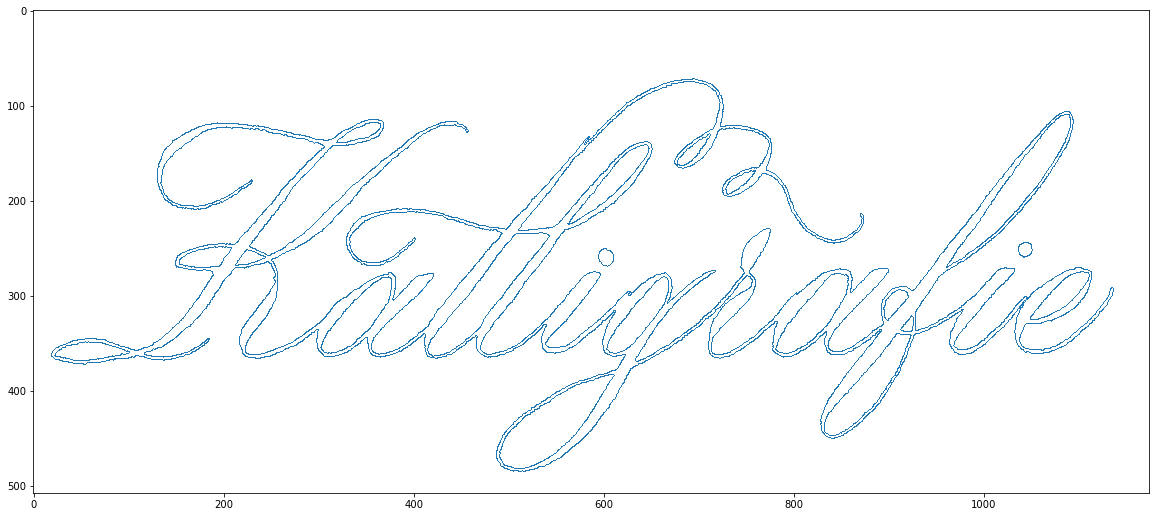

In [182]:
fig, ax = plt.subplots()
ax.imshow(contour_img, alpha=0)  # for shape of plot
ax.plot(all_contours[:, 1], all_contours[:, 0], linestyle='none', marker=',')
plt.show()

In [183]:
#https://stackoverflow.com/questions/14766194/testing-whether-a-numpy-array-contains-a-given-row
any(np.equal(all_contours,[237.5, 542]).all(1))

False

## Split by corners

In [184]:
def split_contour_by_corners(contour, corners):
    segments = []
    first_segmentation_index = -1
    last_segmentation_index = 0
    has_corner = False
    for i, pixel in enumerate(contour):
        for j, corner in enumerate(corners):
            #print(corner[0], pixel[0], corner[1], pixel[1])
            if np.array_equal(corner, pixel):
                has_corner = True
                new_row = contour[last_segmentation_index:(i + 1)]
                segments.append(new_row)
                last_segmentation_index = i
                if first_segmentation_index == -1:
                    first_segmentation_index = i

    if first_segmentation_index > 0:
        new_row = list(contour[last_segmentation_index:len(contour) - 1]) + list(segments[0])
        segments.append(new_row)
        segments.pop(0)
    elif first_segmentation_index == 0:
        # Remove first segment, as the start (& corner) point was added as a single point
        segments.pop(0)
    else:
        new_row = contour[last_segmentation_index:len(contour)]
        segments.append(new_row)

    return segments, has_corner


contours_in_segments = []
contour_has_corner = []
for contour in contours:
    segments, has_corner = split_contour_by_corners(contour, corrected_corners)
    contours_in_segments.append(segments)
    contour_has_corner.append(has_corner)


#contours_in_segments

#for contour in contours_in_segments:
    #print('####################################')
    #for segment in contour:
        #print('--------------------------------')
        #print(segment)
#        points = np.array([segment[:,0], np.flipud(segment[:,1])])
#        print(points)

In [185]:
contours_in_segments[6]

[[array([237.58746858, 542.        ]),
  array([238.        , 542.35136734]),
  array([238.41253147, 542.        ]),
  array([239.        , 541.49981637]),
  array([239.5089931, 541.       ]),
  array([240.        , 540.56661043]),
  array([241.        , 540.43338957]),
  array([241.49098495, 540.        ]),
  array([242.        , 539.49997805]),
  array([242.5, 539. ]),
  array([243.        , 538.50002195]),
  array([243.50901505, 538.        ]),
  array([244.        , 537.56661043]),
  array([245.        , 537.43338957]),
  array([245.49098501, 537.        ]),
  array([246. , 536.5]),
  array([246.50901499, 536.        ]),
  array([247.        , 535.56661043]),
  array([248.        , 535.43338957]),
  array([248.49098495, 535.        ]),
  array([249.        , 534.49997805]),
  array([249.49999995, 534.        ]),
  array([250. , 533.5]),
  array([250.5, 533. ]),
  array([251. , 532.5]),
  array([251.50000005, 532.        ]),
  array([252.        , 531.50002195]),
  array([252.509015

## Curve fitting
https://github.com/volkerp/fitCurves

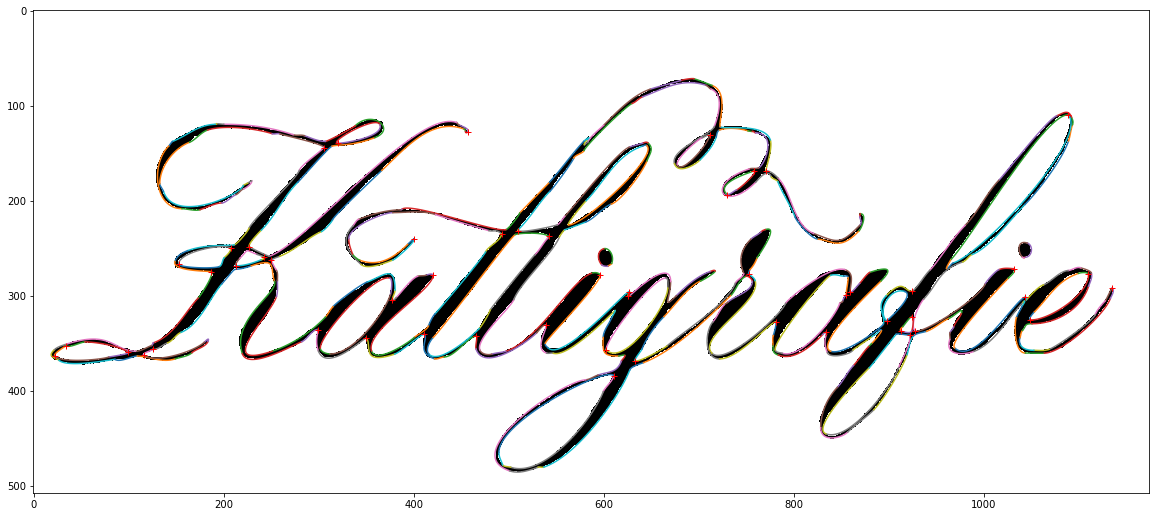

In [186]:
import fitCurves
from fitCurves import *

import importlib

importlib.reload(fitCurves)

maxError = 3
# Also added in library option to choose
splitError = 30
minIterationsBeforeSplit = 10

fig, ax = plt.subplots()
ax.imshow(cleaned_image, cmap=plt.cm.gray, interpolation='nearest')

# Prepare SVG
#import svgwrite
#dwg = svgwrite.Drawing('test-files/test.svg', size=np.shape(cleaned_image)[::-1], profile='tiny')
from libraries import SVG

svg_file = SVG.create_file('test-files/test.svg', np.shape(cleaned_image)[1], np.shape(cleaned_image)[0])
path_string = '\n'

for index, contour in enumerate(contours_in_segments):
    has_corner = contour_has_corner[index]
    svg_path = ''

    for i, segment in enumerate(contour):
        points = segment
        #print(points)

        beziers = fitCurve(points, has_corner, maxError, splitError, minIterationsBeforeSplit)
        #print(beziers)

        for j, bez in enumerate(beziers):
            bez = np.stack(bez)
            bez = np.round(bez, 2)

            # Build SVG path
            if i == 0 and j == 0:
                svg_path = 'M{x0},{y0} C{x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                    x0=bez[0, 1],
                    y0=bez[0, 0],
                    x1=bez[1, 1],
                    y1=bez[1, 0],
                    x2=bez[2, 1],
                    y2=bez[2, 0],
                    x3=bez[3, 1],
                    y3=bez[3, 0]
                )
            else:
                svg_path += ', {x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                    x1=bez[1, 1],
                    y1=bez[1, 0],
                    x2=bez[2, 1],
                    y2=bez[2, 0],
                    x3=bez[3, 1],
                    y3=bez[3, 0]
                )

            curve = []
            for t in np.linspace(0, 1, 50):
                curve.append(bezier.q(bez, t))

            curve = np.stack(curve)
            ax.plot(curve[:, 1], curve[:, 0])

    path_string += f'{svg_path}Z\n'

ax.plot(corrected_corners[:, 1], corrected_corners[:, 0], 'r+')

#plt.savefig('test-files/modCorners3.png', dpi=1200)
SVG.add_path_element(svg_file, path_string)
SVG.save_file(svg_file)